# Solving the Finite Harmonic Oscillator Problem

In [2]:
# Import Statements
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hermite, factorial
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

# Step 0: Solve the Infinite Harmonic Oscillator

From Physics 130 Quantum Mechanics, consider the following potential energy function for the INFINITE harmonic oscillator for a particle of mass $m$ and angular frequency of $w$.

$$V(x) = \frac{1}{2} m \omega^2 x^2$$

We analytically derived the stationary-state solutions to be

$$\psi_n(x) = \pi^{-1/4} \alpha^{1/2} e^{- \frac{(\alpha x)^2}{2}} \frac{H_n(\alpha x )}{2^n n!}
$$

with constant $\alpha = \sqrt{\frac{mw}{\hbar}}$, quantum number $n = 0, 1, 2, ...$, and $H_n$ describing n-th Hermite polynomial.

Below, we plot the potential energy and stationary states for the infinite harmonic oscillator. 


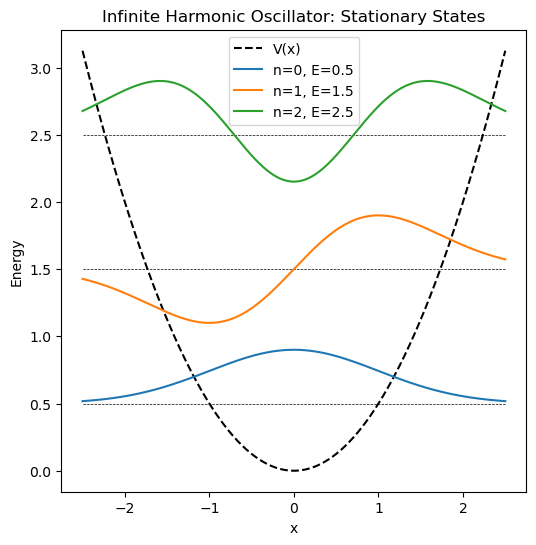

In [3]:
"""
Purpose: computes the INFINITE harmonic oscillator potential
Parameters: position x (float or np array), particle mass m, angular frequency omega
Returns: potential energy at x
"""
def finite_harmonic_potential(x, m=1.0, omega=1.0):
    x = np.asarray(x) 
    return 0.5 * m * omega**2 * x**2

"""
Purpose: computes the n-th stationary state for the finite harmonic oscillator
Parameters: position x (float or np array), constant alpha, quantum number n = 0, 1, 2, ...
Return: wave function at x
"""
def finite_stationary_state(x, alpha, n = 0):
    x = np.asarray(x)
    H_n = hermite(n)  # computes n-th Hermite polynomial with scipy.special
    
    psi_n = np.pi**(-0.25) * alpha**0.5 * np.exp(-0.5 * (alpha * x)**2) * (2**n * factorial(n))**(-0.5) * H_n(alpha * x)
    return psi_n


# DEFINE CONSTANTS
hbar = 1.0  # hbar is 1.054571817e-34 joule·seconds (J·s), but we set it to 1.0 because we don't care about scale
mass = 1.0  # in kg
omega = 1.0  # in seconds ^ -1
x_cutoff = 2.5 * np.sqrt(hbar / (mass * omega))  # defined later in finite case

# Range of position goes a little to the left and right of edge values
x_vals = np.linspace(-x_cutoff, x_cutoff, 400)
V_vals = finite_harmonic_potential(x_vals, mass, omega=1.0)

# PLOT POTENTIAL
plt.figure(figsize=(6, 6))
plt.plot(x_vals, V_vals, 'k--', label = "V(x)")

alpha = np.sqrt(mass * omega / hbar)
N = 3  # plot stationary states from 0, 1, ..., N - 1
for n in range(N):  # PLOT EACH STATIONARY STATE
    E_n = hbar * omega * (n + 0.5)  # nth energy level
    psi_n = finite_stationary_state(x_vals, alpha, n)

    # normalize height to have similar maximum height -- this is to help visualize
    psi_n_scaled = psi_n / np.sqrt(np.max(np.abs(psi_n)**2)) / 2.5
    plt.plot(x_vals, np.full_like(x_vals, E_n), 'k--', linewidth=0.5)  # plot the n-th energy level
    plt.plot(x_vals, psi_n_scaled + E_n, label=f"n={n}, E={E_n:.1f}")  # plot n-th wave function offset by the n-th energy level -- this is to help visualize


plt.title("Infinite Harmonic Oscillator: Stationary States")
plt.xlabel("x")
plt.ylabel("Energy")
plt.legend()
plt.show()


Note that the turning points on the wave function $\psi_n$ occur when it crosses the x-axis (horizontal line $E_n$ for $\psi_n$) and when $V(x)$ intersects $E_n$.

# Step 1: Define and Plot the FINITE Harmonic Oscillator Potential

Now let us instead consider the FINITE harmonic oscillator, defined by the following potential energy function.

\begin{equation}
V(x) =
\begin{cases}
\frac{1}{2} m \omega^2 x^2, & |x| < 2\sqrt{\frac{\hbar}{mw}} \\
0, & |x| \geq 2\sqrt{\frac{\hbar}{mw}}
\end{cases}
\end{equation}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


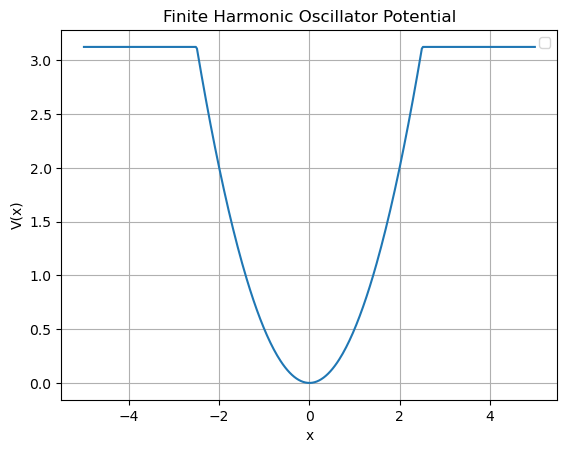

In [16]:
"""
Purpose: defines the FINITE harmonic oscillator potential
Parameters: position x (float or np array), particle mass m, angular frequency omega
Returns: potential energy at x
"""
from ipywidgets import interact, FloatSlider
def finite_harmonic_potential(x, m=1.0, omega=1.0, x_cut=x_cutoff):
    x = np.asarray(x)

    # evalutes to 0.5mw^2x^2 if absolute value of position is within x_cutoff
    V = np.where(
        np.abs(x) < x_cut,
        0.5 * m * omega**2 * x**2,
        0.5 * m * omega**2 * x_cut**2
    )
    return V

# DEFINE CONSTANTS
mass = 1.0  # in kg
omega = 1.0  # in seconds ^ -1

x_vals = np.linspace(-5, 5, 400)
V_vals = finite_harmonic_potential(x_vals, mass, omega)

plt.plot(x_vals, V_vals)
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Finite Harmonic Oscillator Potential")
plt.grid(True)
plt.legend()
plt.show()

In [17]:
def interactiveFHP(cutoff):
    x_vals = np.linspace(-5, 5, 400)
    V_vals = finite_harmonic_potential(x_vals, x_cut=cutoff)

    plt.plot(x_vals, V_vals)
    plt.xlabel("x")
    plt.ylabel("V(x)")
    plt.title("Finite Harmonic Oscillator Potential")
    plt.grid(True)
    plt.legend()
    plt.show()


interact(interactiveFHP, x=x_cutoff)


ValueError: cannot find widget or abbreviation for argument: 'cutoff'

# Step 2: Numerically Solve the FINITE Harmonic Oscillator Potential

Since this problem has no analytical solution, we must numerically solve the Time-Independent Schrodinger Equation (TISE) using the Shooting Method (introduced in Physics 113's Chaotic Systems notebook).

First we start with TISE as below:
$$- \frac{\hbar^2}{2m} \frac{d^2 \psi(x)}{dx^2} + V(x)\psi(x) = E\psi(x)$$

Define $\phi(x) = \frac{d\psi}{dx}$. Then plugging $\phi$ into TISE, we get the following system of first-order ODEs:
$$\frac{d\psi}{dx} = \phi$$
$$\frac{d\phi}{dx} = \frac{2m}{\hbar^2}(V(x) - E)\psi$$
By rewriting the problem as a first-order system, we can use scipy.integrate's solve_ivp method.

In [6]:
x_domain = (-x_cutoff, x_cutoff)  # domain of x goes from left wall to right wall
V_vec = np.vectorize(finite_harmonic_potential)  # vectorized version for plotting or integration

"""
Purpose: computes the right-hand side of TISE given the current position, energy, and [psi, dpsi/dx]
Parameters: position x, energy E, and list y = [psi, dpsi/dx] = [psi, phi]
Returns: the derivatives of y, which is [phi, dphi/dx]
"""
def schrodinger_rhs(x, y, E):
    psi, phi = y  # unpack y
    V = finite_harmonic_potential(x)
    dphi_dx = (2 * mass / hbar**2) * (V - E) * psi  # defined in first-order system described earlier
    return [phi, dphi_dx]

"""
Purpose: given trial energy E_guess, this function integrates TISE from -x_cutoff to +x_cutoff
            and then returns psi(x_cutoff)
Parameters: trial energy E_guess (float)
Return: psi(x_cutoff)
"""
def shooting_method(E_guess):
    y0 = [1e-5, 0.0]  # initial guess: small non-zero psi, zero derivative
    sol = solve_ivp(schrodinger_rhs, x_domain, y0, args=(E_guess,), dense_output=True, max_step=0.05)
    psi_xmax = sol.y[0, -1]
    return psi_xmax

# Function to find the energy eigenvalue using root-finding

"""
Purpose: given the bracket of energy guesses, first evaluate psi(x_max) using the shooting method
    Then find the root (i.e. the energy eigenvalue) using the bisection method
Parameters: low and high guesses for energy eigenvalue
Return: the root -> energy eigenvalue within the bracket
"""
def find_energy_eigenvalue(E_guess_low, E_guess_high):
    # evaluate psi_xmax at low and high guess
    f_low = shooting_method(E_guess_low) 
    f_high = shooting_method(E_guess_high)

    if f_low * f_high > 0:  # checks if root-finding method works (using bisection method)
        raise ValueError("Shooting function does not change sign - widen energy guesses bracket")

    sol = root_scalar(shooting_method, bracket=[E_guess_low, E_guess_high], method='bisect')
    return sol.root

# Energies range to search for roots
E_min = 0.0
E_max = 3.0  # estimated based off E_2 in infinite case, which is 2.5 
num_points = 100
energies = np.linspace(E_min, E_max, num_points)

# Below, we find energy intervals where psi(x_max) changes sign (indicating a root to search for with the shooting method)
psi_end_values = [shooting_method(E) for E in energies]
sign_changes = []
for i in range(num_points - 1):
    if psi_end_values[i] * psi_end_values[i+1] < 0:  # sign change found
        sign_changes.append((energies[i], energies[i+1]))  # append energy interval

# Find roots (i.e. energy eigenvalues) using root_scalar with bisection method
energy_eigenvalues = []
for E_low, E_high in sign_changes:  # for each energy search interval to check
    root = root_scalar(shooting_method, bracket=[E_low, E_high], method='bisect')
    energy_eigenvalues.append(root.root)

print("Found Energy Eigenvalues:")

# Plot wavefunctions psi_n for the found energy eigenvalues
y0 = [1e-5, 0.0]
for n, E_n in enumerate(energy_eigenvalues):
    print(f"n = {n} → E = {E_n:.6f}")

    # Solves TISE for the energy eigenvalue E_n, returns [psi(x), dpsi/dx]
    sol_n = solve_ivp(schrodinger_rhs, x_domain, y0, args=(E_n,), t_eval=x_vals, max_step=0.01)
    psi_n = sol_n.y[0]  # psi(x)

    # Normalizes wave function and scales for visualization purposes
    norm = np.trapz(np.abs(psi_n)**2, x_vals)
    psi_n_scaled = psi_n / np.sqrt(norm) / 1.5
    
    plt.plot(x_vals, np.full_like(x_vals, E_n), 'k--', linewidth=0.5)  # plot the n-th energy level
    # Plot wavefunction shifted by energy level for visualization purposes
    plt.plot(x_vals, psi_n_scaled + E_n, label=f"n={n}, E={E_n:.3f}")

# Plot finite potential V(x)
plt.plot(x_vals, V_vec(x_vals), 'k--', label="Potential V(x)")

plt.title("Finite Harmonic Oscillator: Stationary States")
plt.xlabel("x")
plt.ylabel("Energy")
plt.legend()
plt.show()

Found Energy Eigenvalues:
n = 0 → E = 0.499365


ValueError: Values in `t_eval` are not within `t_span`.